Part 1: Download the MNIST Dataset

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.datasets import MNIST
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [79]:
# a google search said the mean and stdev are 0.1307 and 0.3081

# why normalization is done:
# it's done because it makes it work better with the neural net. for example, if the
# values were kept as byte values from 0 to 255, the features' values would produce extreme
# activation values.
pil_to_tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

training_data = MNIST(root="./data", train=True, download=True, transform=pil_to_tensor_transform)
testing_data = MNIST(root="./data", train=False, download=True, transform=pil_to_tensor_transform)

Part 2: Prepare the Data

MNIST dataset explanation:
It's a dataset that has pictures of handwritten digits from 0 to 9.
- The dataset has 60000 training images and 10000 test images
- There are ten classes, each digit from 0 to 9.
- The images are 28x28 pixels large.

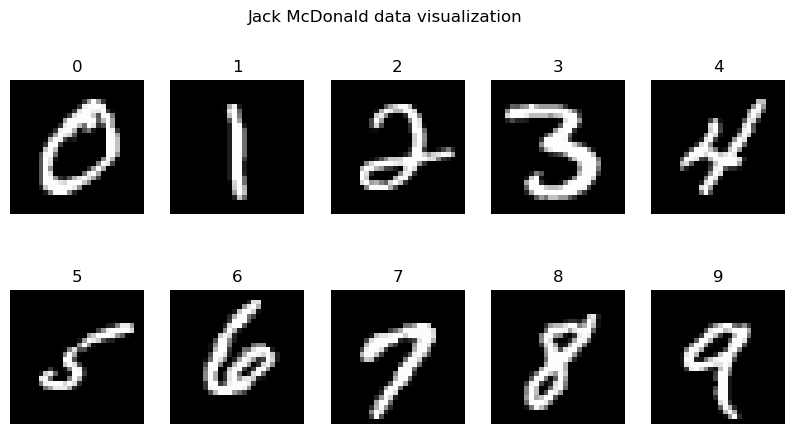

In [82]:
# visualization of the data

images_for_visualization = [None] * 10
examples_still_needed = 10

for image, label in training_data:
    examples_still_needed -= (images_for_visualization[label] is None)
    images_for_visualization[label] = torch.squeeze(image)
    
    if examples_still_needed == 0:
        break

figure, axes = plt.subplots(2, 5, figsize=(10, 5))
figure.suptitle("Jack McDonald data visualization")
for label, axis in enumerate(axes.flat):
    axis.axis("off")
    axis.set_title(f"{label}")
    axis.imshow(images_for_visualization[label], cmap='gray')


In [83]:
# setting up the data loader

BATCH_SIZE = 256

training_data_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
testing_data_loader = torch.utils.data.DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=False)

Part 3: Build a CNN Model

In [85]:
class MNIST_CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2), # reduced to 14x14
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2), # reduced to 7x7
            torch.nn.Flatten(),
            torch.nn.Linear(16 * 7 * 7, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10) # output
        )
        
    def forward(self, x):
        out = self.main(x)
        return out


In [86]:
# showing a model summary

model=MNIST_CNN()
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           1,168
              ReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
           Flatten-7                  [-1, 784]               0
            Linear-8                   [-1, 64]          50,240
              ReLU-9                   [-1, 64]               0
           Linear-10                  [-1, 128]           8,320
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 61,098
Trainable params: 61,098
Non-trainable params: 0
---------------------------------

In [87]:
# training

def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    """
    The trainer class we learned from lecture
    """

    current_epoch = 0
    train_loss, valid_loss, valid_accuracy = [], [], []
    while current_epoch < epochs:
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        model.train()
        for X, y in trainloader:
            optimizer.zero_grad() # Reset gradients
            y_hat = model(X) # Forward pass: compute the model's prediction
            loss = criterion(y_hat, y) # Compute loss between predicted values and actual labels
            loss.backward() # Backpropagation: compute gradients
            optimizer.step() # Update model parameters using optimizer
            train_batch_loss += loss.item() # Accumulate batch loss
        train_loss.append(train_batch_loss / len(trainloader)) # Compute average training loss for this epoch
        
        # Validation
        model.eval() # Set the model to evaluation mode (disables dropout/batchnorm layers if any)
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                y_hat = model(X) # Forward pass: compute predictions for validation set
                y_hat_labels = torch.argmax(y_hat, axis=1) # Find which digit is most likely
                loss = criterion(y_hat, y) # Compute validation loss
                valid_batch_loss += loss.item() # Accumulate validation batch loss
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item() # Compute validation accuracy: compare predicted labels to actual labels
        valid_loss.append(valid_batch_loss / len(validloader)) # Compute average validation loss for this epoch
        current_accuracy = valid_batch_acc / len(validloader)
        valid_accuracy.append(valid_batch_acc / len(validloader))  # Compute average validation accuracy for this epoch
        current_epoch += 1
        
        # Print progress
        if verbose:
            print(f"Epoch {current_epoch}:",
                  f"Train Loss: {train_loss[-1]:.5f}.",
                  f"Valid Loss: {valid_loss[-1]:.5f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.5f}.")
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}
    return results


model = MNIST_CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
results = trainer(model, criterion, optimizer, training_data_loader, testing_data_loader, epochs=50)

print("done training")

Epoch 1: Train Loss: 1.62964. Valid Loss: 0.73313. Valid Accuracy: 0.82021.
Epoch 2: Train Loss: 0.51456. Valid Loss: 0.36864. Valid Accuracy: 0.89697.
Epoch 3: Train Loss: 0.32286. Valid Loss: 0.26628. Valid Accuracy: 0.92480.
Epoch 4: Train Loss: 0.25071. Valid Loss: 0.21638. Valid Accuracy: 0.93818.
Epoch 5: Train Loss: 0.20960. Valid Loss: 0.17953. Valid Accuracy: 0.94922.
Epoch 6: Train Loss: 0.17990. Valid Loss: 0.15552. Valid Accuracy: 0.95381.
Epoch 7: Train Loss: 0.15724. Valid Loss: 0.13893. Valid Accuracy: 0.95859.
Epoch 8: Train Loss: 0.14075. Valid Loss: 0.12331. Valid Accuracy: 0.96309.
Epoch 9: Train Loss: 0.12726. Valid Loss: 0.10981. Valid Accuracy: 0.96719.
Epoch 10: Train Loss: 0.11625. Valid Loss: 0.10236. Valid Accuracy: 0.96943.
Epoch 11: Train Loss: 0.10764. Valid Loss: 0.09690. Valid Accuracy: 0.97227.
Epoch 12: Train Loss: 0.10028. Valid Loss: 0.08895. Valid Accuracy: 0.97354.
Epoch 13: Train Loss: 0.09339. Valid Loss: 0.08265. Valid Accuracy: 0.97471.
Epoch 14

Part 4: Visualize and Evaluation

Text(0.5, 1.0, 'Jack McDonald training loss curve')

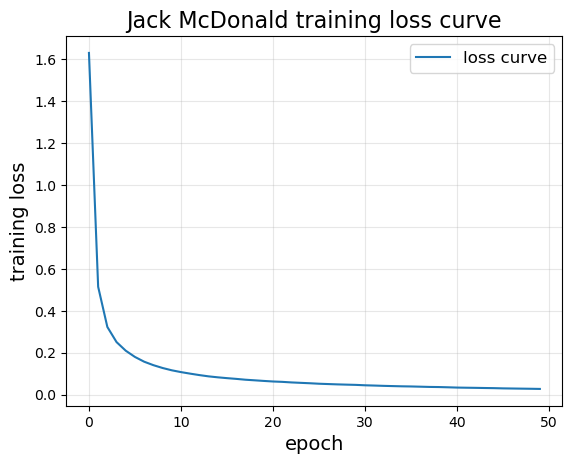

In [89]:
# training loss

plt.plot(results["train_loss"])
plt.xlabel("epoch", fontsize=14)
plt.ylabel("training loss", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(["loss curve"], fontsize=12)
plt.title("Jack McDonald training loss curve", fontsize=16)

It gets pretty close to zero. It's mostly flat by 40 epochs.

Text(0.5, 1.0, 'Jack McDonald validation loss curve')

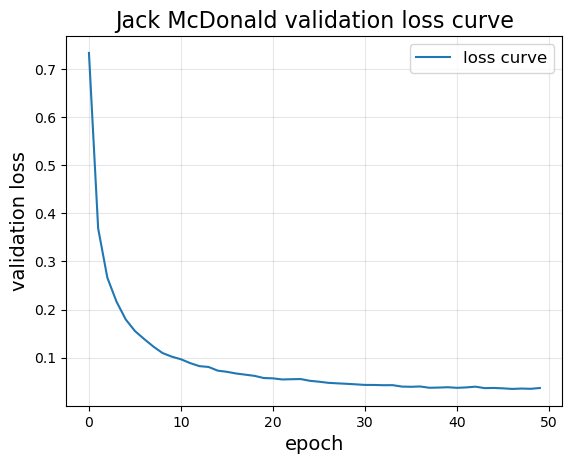

In [91]:
# validation loss

plt.plot(results["valid_loss"])
plt.xlabel("epoch", fontsize=14)
plt.ylabel("validation loss", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(["loss curve"], fontsize=12)
plt.title("Jack McDonald validation loss curve", fontsize=16)

The validation loss goes down and gets mostly flat by 40 epochs.

Text(0.5, 1.0, 'Jack McDonald validation accuracy curve')

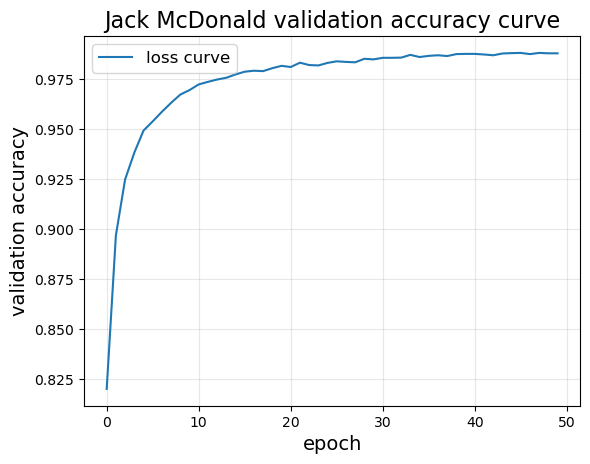

In [93]:
plt.plot(results["valid_accuracy"])
plt.xlabel("epoch", fontsize=14)
plt.ylabel("validation accuracy", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(["loss curve"], fontsize=12)
plt.title("Jack McDonald validation accuracy curve", fontsize=16)

The accuracy ended up staying around 98.7% by 40 epochs.

In [95]:
# getting test data

guesses = []
correct_answers = []
for test in testing_data:
    guesses.append(torch.argmax(model(test[0].unsqueeze(0))).item())
    correct_answers.append(test[1])

print(guesses[:10])
print(correct_answers[:10])

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


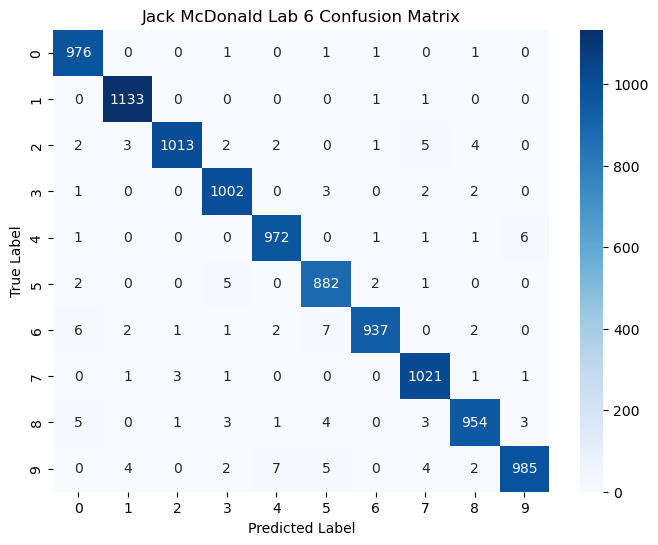

In [96]:
# confusion matrix

confusion_matrix = confusion_matrix(correct_answers, guesses)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Jack McDonald Lab 6 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [97]:
# finding prediction and misprediction rates per digit
correct_guesses = [0] * 10
incorrect_guesses = [0] * 10

for guess, correct_answer in zip(guesses, correct_answers):
    if guess == correct_answer:
        correct_guesses[correct_answer] += 1
    else:
        incorrect_guesses[correct_answer] += 1

print(correct_guesses)
print(incorrect_guesses)

[976, 1133, 1013, 1002, 972, 882, 937, 1021, 954, 985]
[4, 2, 19, 8, 10, 10, 21, 7, 20, 24]


Text(0.5, 1.0, 'Jack McDonald correct guesses')

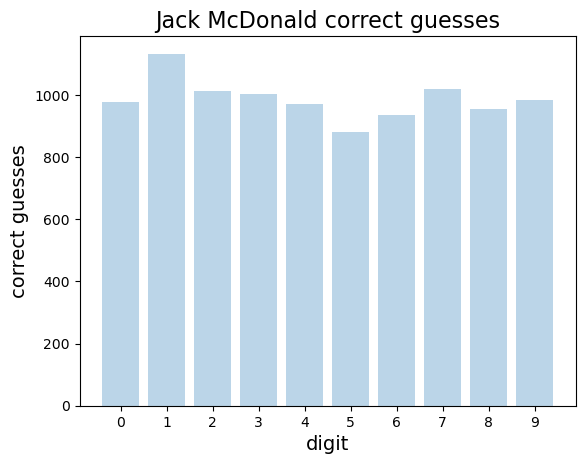

In [98]:
# showing the correct guess rate per digit

plt.bar(list(map(str, range(10))), correct_guesses, alpha=0.3)
plt.xlabel("digit", fontsize=14)
plt.ylabel("correct guesses", fontsize=14)
plt.title("Jack McDonald correct guesses", fontsize=16)

Text(0.5, 1.0, 'Jack McDonald incorrect guesses')

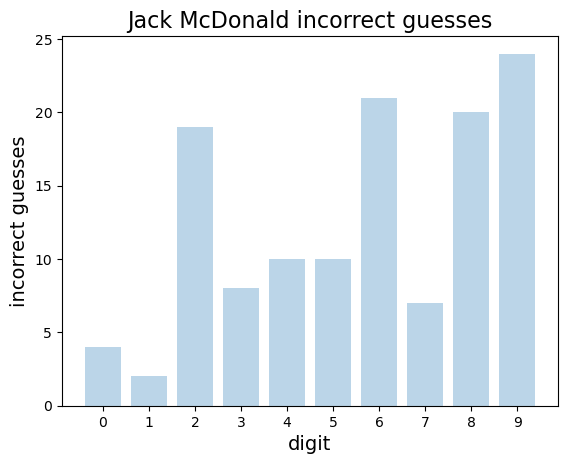

In [99]:
# showing the incorrect guess rate per digit

plt.bar(list(map(str, range(10))), incorrect_guesses, alpha=0.3)
plt.xlabel("digit", fontsize=14)
plt.ylabel("incorrect guesses", fontsize=14)
plt.title("Jack McDonald incorrect guesses", fontsize=16)

It's good at predicting 1, maybe because 1 is so visually simple, it's just a line. It has a hard time predicting 9. The confusion matrix shows that it confuses 9 with 4 a lot. Maybe because 4 kind of looks like a 9 with a straight tail and a less round circular part.

Part 5: Save and Upload Your Work

In [102]:
torch.save(model, "./lab_6_model.pt")